# Computer Vision Assignment 2 Question 3
## Downloading Necessary Modules

Name: Dishanand Jayeprokash

In [ ]:
!pip install gdown tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting the Data

In [ ]:
import gdown
!gdown --id 1M-t2LBkKa0-J9SlsYZgHNI2MPkhOSmGm

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1M-t2LBkKa0-J9SlsYZgHNI2MPkhOSmGm
From (redirected): https://drive.google.com/uc?id=1M-t2LBkKa0-J9SlsYZgHNI2MPkhOSmGm&confirm=t&uuid=ec3b461a-a243-4b45-87ac-3b3c17569543
To: /kaggle/working/VeRi.zip
100%|█████████████████████████████████████████| 991M/991M [00:05<00:00, 182MB/s]


In [ ]:
import zipfile

def unzip_file(path, dest_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(dest_path)

In [ ]:
path = "VeRi.zip"
unzip_file(path, "./")

In [ ]:
!pip install lxml


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import pandas as pd
import cv2

2024-06-01 12:20:53.687521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 12:20:53.687615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 12:20:53.824590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Extracting Information from xml Files

In [ ]:
# Kaggle-specific setup
BASE_DIR = '/kaggle/working/VeRi/'

# Function to parse XML and get vehicle IDs using lxml
def parse_xml(xml_path):
    xmlp = etree.XMLParser(encoding = 'utf-8')
    tree = etree.parse(xml_path, parser = xmlp)
    root = tree.getroot()
    data = []
    for item in root.find('Items').findall('Item'):
        image_name = item.get('imageName')
        vehicle_id = item.get('vehicleID')
        camera_id = item.get('cameraID')
        color_id = item.get('colorID')
        type_id = item.get('typeID')
        data.append({'imageName': image_name,
                     'vehicleID': vehicle_id,
                     'cameraID': camera_id,
                     'colorID': color_id,
                     'typeID': type_id})

    return pd.DataFrame(data)

# Parse train and test labels
train_labels_path = os.path.join(BASE_DIR, 'train_label.xml')
test_labels_path = os.path.join(BASE_DIR, 'test_label.xml')

# Load train and test labels
data_train = parse_xml(train_labels_path)
data_test = parse_xml(test_labels_path)


In [ ]:
data_train

imageName vehicleID cameraID colorID typeID
0      0001_c001_00016450_0.jpg      0001     c001       1      4
1      0001_c001_00016460_0.jpg      0001     c001       1      4
2      0001_c001_00016470_0.jpg      0001     c001       1      4
3      0001_c001_00016480_0.jpg      0001     c001       1      4
4      0001_c001_00016490_0.jpg      0001     c001       1      4
...                         ...       ...      ...     ...    ...
37741  0769_c019_00075220_0.jpg      0769     c019      10      1
37742  0769_c019_00075235_0.jpg      0769     c019      10      1
37743  0769_c019_00075250_0.jpg      0769     c019      10      1
37744  0769_c019_00075255_0.jpg      0769     c019      10      1
37745  0769_c019_00075275_0.jpg      0769     c019      10      1

[37746 rows x 5 columns]

In [ ]:
data_test.head()

imageName vehicleID cameraID colorID typeID
0  0002_c002_00030600_0.jpg      0002     c002       1      4
1  0002_c002_00030605_1.jpg      0002     c002       1      4
2  0002_c002_00030615_1.jpg      0002     c002       1      4
3  0002_c002_00030625_1.jpg      0002     c002       1      4
4  0002_c002_00030640_0.jpg      0002     c002       1      4

## Visualizing the Training Images

In [ ]:
# Function to visualize random images with their vehicle IDs
def visualize_random_images_with_ids(image_dir, labels_df, num_images=9, scale_factor=1):
    sample_files = random.sample(os.listdir(image_dir), num_images)
    fig, axes = plt.subplots(3, 3, figsize=(9,9))
    axes = axes.ravel()
    for ax, file in zip(axes, sample_files):
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224), fx=scale_factor, fy=scale_factor)
        # Get the vehicle ID based on the filename
        vehicle_id = file.split('_')[0]
        camera_id = file.split('_')[1]
        ax.imshow(img)
        ax.set_title(f'VeID: {vehicle_id}, CamID: {camera_id}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualize random images with their vehicle IDs
visualize_random_images_with_ids(os.path.join(BASE_DIR, 'image_train'), data_train)


## Splitting the Training Images to Training and Validation

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Function to split the dataset
def split_dataset(dataframe, image_dir, train_dir, val_dir, test_size=0.2, random_state=42):
    train_df, val_df = train_test_split(dataframe, test_size=test_size, stratify=dataframe['vehicleID'], random_state=random_state)

    # Create directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Move files to the respective directories
    for _, row in train_df.iterrows():
        src = os.path.join(image_dir, row['imageName'])
        dst = os.path.join(train_dir, row['imageName'])
        shutil.copyfile(src, dst)

    for _, row in val_df.iterrows():
        src = os.path.join(image_dir, row['imageName'])
        dst = os.path.join(val_dir, row['imageName'])
        shutil.copyfile(src, dst)

    return train_df, val_df

# Directories
image_dir = os.path.join(BASE_DIR, 'image_train')
train_dir = os.path.join(BASE_DIR, 'image_train_split/train')
val_dir = os.path.join(BASE_DIR, 'image_train_split/val')

# Split dataset
train_df, val_df = split_dataset(data_train, image_dir, train_dir, val_dir)

# Verify the split
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")


Training set: 30196 images
Validation set: 7550 images


In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import os

# Function to visualize a random image with vehicleID and cameraID, and print the full image name
def visualize_random_image_with_ids(image_dir, labels_df):
    random_image = random.choice(labels_df['imageName'].values)
    img_path = os.path.join(image_dir, random_image)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_row = labels_df[labels_df['imageName'] == random_image].iloc[0]
    vehicle_id = label_row['vehicleID']
    camera_id = label_row['cameraID']

    plt.imshow(img)
    plt.title(f'VeID: {vehicle_id}, CamID: {camera_id}')
    plt.axis('off')
    plt.show()
    print(f'Full Image Name: {random_image}')

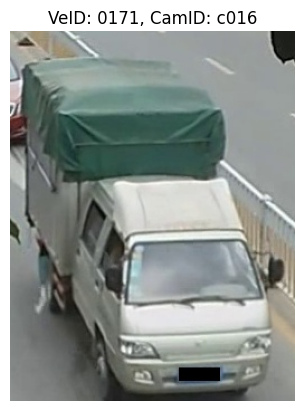

Full Image Name: 0171_c016_00052735_0.jpg


In [ ]:
# Visualize a random image from the training set
visualize_random_image_with_ids(train_dir, train_df)

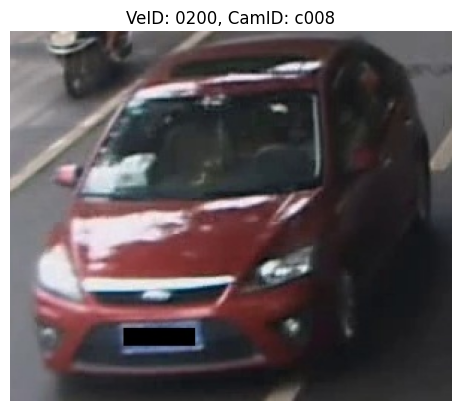

Full Image Name: 0200_c008_00044995_0.jpg


In [ ]:
# Visualize and print a random image from the validation set
visualize_random_image_with_ids(val_dir, val_df)

In [ ]:
train_df

imageName vehicleID cameraID colorID typeID
9010   0194_c011_00021945_0.jpg      0194     c011       5      5
19198  0376_c009_00043755_0.jpg      0376     c009       7      2
19615  0384_c013_00044425_0.jpg      0384     c013       7      2
12933  0268_c014_00043070_1.jpg      0268     c014       6      7
20163  0395_c016_00076440_0.jpg      0395     c016       1      8
...                         ...       ...      ...     ...    ...
31920  0639_c003_00086020_0.jpg      0639     c003      10      1
1240   0023_c015_00013865_0.jpg      0023     c015       5      1
17547  0347_c011_00015040_0.jpg      0347     c011       7      1
26424  0520_c016_00086285_0.jpg      0520     c016       4      1
34582  0707_c014_00070340_1.jpg      0707     c014      10      1

[30196 rows x 5 columns]

In [ ]:
val_df

imageName vehicleID cameraID colorID typeID
15786  0308_c015_00068685_0.jpg      0308     c015       7      3
5127   0088_c015_00058725_0.jpg      0088     c015       3      6
21995  0429_c014_00026715_0.jpg      0429     c014       4      4
3450   0056_c006_00007535_0.jpg      0056     c006       7      6
11761  0246_c003_00048780_0.jpg      0246     c003       8      3
...                         ...       ...      ...     ...    ...
4922   0084_c004_00016075_0.jpg      0084     c004       4      6
25263  0496_c013_00034560_0.jpg      0496     c013       4      1
23539  0455_c015_00021620_0.jpg      0455     c015       4      1
146    0007_c019_00048650_1.jpg      0007     c019       2      2
35766  0731_c019_00028535_0.jpg      0731     c019      10      1

[7550 rows x 5 columns]

## Building the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os

# Constants
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)
EMBEDDING_DIM = 512
alpha = 0.5
BATCH_SIZE = 32

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)


In [ ]:
# Triplet loss function
def triplet_loss(y_true, y_pred, margin=alpha):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    return tf.reduce_mean(loss)

In [ ]:
# Custom accuracy function
def triplet_accuracy(y_true, y_pred):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    return tf.reduce_mean(tf.cast(positive_distance < negative_distance, tf.float32))


In [ ]:
# Add custom layers on top
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(EMBEDDING_DIM)(x)

# Define the complete model
embedding_model = Model(inputs=base_model.input, outputs=x)

from tensorflow.keras.layers import Lambda

# Input layers for anchor, positive, and negative images
input_anchor = Input(shape=IMG_SHAPE)
input_positive = Input(shape=IMG_SHAPE)
input_negative = Input(shape=IMG_SHAPE)

# Generate embeddings for each input
embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

# Stack embeddings together
output = Lambda(lambda x: tf.stack(x, axis=1))([embedding_anchor, embedding_positive, embedding_negative])

# Define the triplet model
triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=output)
triplet_model.compile(optimizer=Adam(learning_rate=0.00001), loss=triplet_loss, metrics=[triplet_accuracy])
triplet_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_9 (Functional)        (None, 512)                  2489945   ['input_16[0][0]',            
                                                          6          'input_17[0][0]',     

In [ ]:
# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss=triplet_loss, metrics=[triplet_accuracy])


In [ ]:
# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [ ]:
# Function to generate triplets
def generate_triplets(data_df, image_dir, batch_size=BATCH_SIZE):
    while True:
        anchors, positives, negatives = [], [], []
        for iter in range(batch_size):
            anchor_row = data_df.sample(n=1).iloc[0]
            anchor_image = preprocess_image(os.path.join(image_dir, anchor_row['imageName']))

            positive_row = data_df[data_df['vehicleID'] == anchor_row['vehicleID']].sample(n=1).iloc[0]
            positive_image = preprocess_image(os.path.join(image_dir, positive_row['imageName']))

            negative_row = data_df[data_df['vehicleID'] != anchor_row['vehicleID']].sample(n=1).iloc[0]
            negative_image = preprocess_image(os.path.join(image_dir, negative_row['imageName']))

            anchors.append(anchor_image)
            positives.append(positive_image)
            negatives.append(negative_image)

        yield (np.array(anchors), np.array(positives), np.array(negatives)), np.array((batch_size, 1))


In [ ]:
# Directories for training and validation images
BASE_DIR = '/kaggle/working/VeRi'
train_dir = os.path.join(BASE_DIR, 'image_train')
val_dir = os.path.join(BASE_DIR, 'image_train')

# Generators for training and validation
train_generator = generate_triplets(train_df, train_dir)
val_generator = generate_triplets(val_df, val_dir)

# Train the model
history = triplet_model.fit(train_generator, steps_per_epoch=len(train_df) // BATCH_SIZE,
                    validation_data=val_generator, validation_steps=len(val_df) // BATCH_SIZE, epochs=3)

# Evaluate the model (example, adjust as needed)
# loss = model.evaluate(test_generator)

Epoch 1/3
943/943 [==============================] - 808s 819ms/step - loss: 4.9273 - triplet_accuracy: 0.6449 - val_loss: 0.3773 - val_triplet_accuracy: 0.7918
Epoch 2/3
943/943 [==============================] - 806s 856ms/step - loss: 0.6721 - triplet_accuracy: 0.6204 - val_loss: 0.2980 - val_triplet_accuracy: 0.7475
Epoch 3/3
943/943 [==============================] - 749s 795ms/step - loss: 0.4286 - triplet_accuracy: 0.6395 - val_loss: 0.2432 - val_triplet_accuracy: 0.8028


In [ ]:
# Plotting training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['triplet_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_triplet_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Model

In [ ]:
# Save the model
model_path = '/kaggle/working/vehicle_reid_model.h5'
model.save(model_path)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Extract Embeddings

In [ ]:
# Function to extract embeddings from a list of images
def extract_embeddings(model, image_dir, image_list):
    embeddings = []
    for image_name in image_list:
        image_path = os.path.join(image_dir, image_name)
        img = preprocess_image(image_path)
        img = np.expand_dims(img, axis=0)
        embedding = model.predict(img)
        embeddings.append(embedding[0])
    return np.array(embeddings)

## Mean Average Precision

In [ ]:
def compute_ap(ranks, n):
    """
    Compute the average precision (AP) for a single query.
    """
    ap = 0.0
    for i in range(n):
        if ranks[i]:
            ap += sum(ranks[:i+1]) / (i+1)
    ap /= n
    return ap

def compute_map(query_embeddings, test_embeddings, query_labels, test_labels):
    """
    Compute the mean average precision (mAP) over the full query set.
    """
    average_precisions = []

    for query_embedding, query_label in zip(query_embeddings, query_labels):
        distances = pairwise_distances(query_embedding.reshape(1, -1), test_embeddings, metric='euclidean')[0]
        sorted_indices = np.argsort(distances)
        sorted_labels = np.array(test_labels)[sorted_indices]

        # Generate binary relevance vector
        relevance = [1 if label == query_label else 0 for label in sorted_labels]
        ap = compute_ap(relevance, len(relevance))
        average_precisions.append(ap)

    return np.mean(average_precisions)

In [ ]:
import os
print(os.getcwd())


/kaggle/working


In [ ]:
print(os.listdir('/kaggle/working'))


['vehicle_reid_model.h5', '.virtual_documents', 'VeRi.zip', 'VeRi']


## Load the Model

In [ ]:
# Load the model
model = tf.keras.models.load_model(model_path, custom_objects={'triplet_loss': triplet_loss, 'triplet_accuracy': triplet_accuracy})


In [ ]:
# Directories for query and test images
query_dir = os.path.join(BASE_DIR, 'image_query')
test_dir = os.path.join(BASE_DIR, 'image_test')

# List of query and test images
query_images = os.listdir(query_dir)
test_images = os.listdir(test_dir)

# Extract embeddings for query and test images
query_embeddings = extract_embeddings(model, query_dir, query_images)
test_embeddings = extract_embeddings(model, test_dir, test_images)

1/1 [==============================] - 0s 22ms/step


In [ ]:
from sklearn.metrics import pairwise_distances

# Extract labels (vehicleID) from image names
query_labels = [img.split('_')[0] for img in query_images]
test_labels = [img.split('_')[0] for img in test_images]

# Compute mAP
map_score = compute_map(query_embeddings, test_embeddings, query_labels, test_labels)
# map_score = compute_map(query_embeddings, query_embeddings, query_labels, query_labels)
print(f"Mean Average Precision (mAP): {map_score:.4f}")

Mean Average Precision (mAP): 0.0003


## Visualizing the Query and Ranking

In [ ]:
# Visualize top ranked images
def visualize_top_ranked_images(query_images, query_embeddings, test_images, test_embeddings, num_queries=3, top_k=5):
    indices = np.random.choice(len(query_images), num_queries, replace=False)
    fig, axes = plt.subplots(num_queries, top_k + 1, figsize=(18, 9))

    for i, idx in enumerate(indices):
        query_image = query_images[idx]
        query_embedding = query_embeddings[idx]

        distances = pairwise_distances(query_embedding.reshape(1, -1), test_embeddings, metric='euclidean')[0]
        top_k_indices = np.argsort(distances)[:top_k]

        query_img = cv2.imread(os.path.join(query_dir, query_image))
        query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
        axes[i, 0].imshow(query_img)
        axes[i, 0].set_title(f'Query {i+1}')
        axes[i, 0].axis('off')

        print(f"Query {i+1} image name: {query_image}")

        for j, test_idx in enumerate(top_k_indices):
            test_image = test_images[test_idx]
            test_img = cv2.imread(os.path.join(test_dir, test_image))
            test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
            axes[i, j+1].imshow(test_img)
            axes[i, j+1].set_title(f'Rank {j+1}')
            axes[i, j+1].axis('off')

            print(f"Rank {j+1} image name: {test_image}")

    plt.tight_layout()
    plt.show()

Query 1 image name: 0405_c004_00046160_0.jpg
Rank 1 image name: 0405_c004_00046160_0.jpg
Rank 2 image name: 0405_c004_00046145_0.jpg
Rank 3 image name: 0405_c001_00062250_0.jpg
Rank 4 image name: 0404_c016_00013265_0.jpg
Rank 5 image name: 0392_c001_00003295_0.jpg
Query 2 image name: 0247_c017_00083635_0.jpg
Rank 1 image name: 0247_c017_00083635_0.jpg
Rank 2 image name: 0247_c017_00083630_0.jpg
Rank 3 image name: 0247_c017_00083620_0.jpg
Rank 4 image name: 0770_c017_00032375_0.jpg
Rank 5 image name: 0106_c017_00018825_0.jpg
Query 3 image name: 0247_c015_00082380_0.jpg
Rank 1 image name: 0247_c015_00082380_0.jpg
Rank 2 image name: 0569_c015_00085580_0.jpg
Rank 3 image name: 0247_c015_00082390_0.jpg
Rank 4 image name: 0247_c015_00082385_0.jpg
Rank 5 image name: 0602_c015_00022155_1.jpg


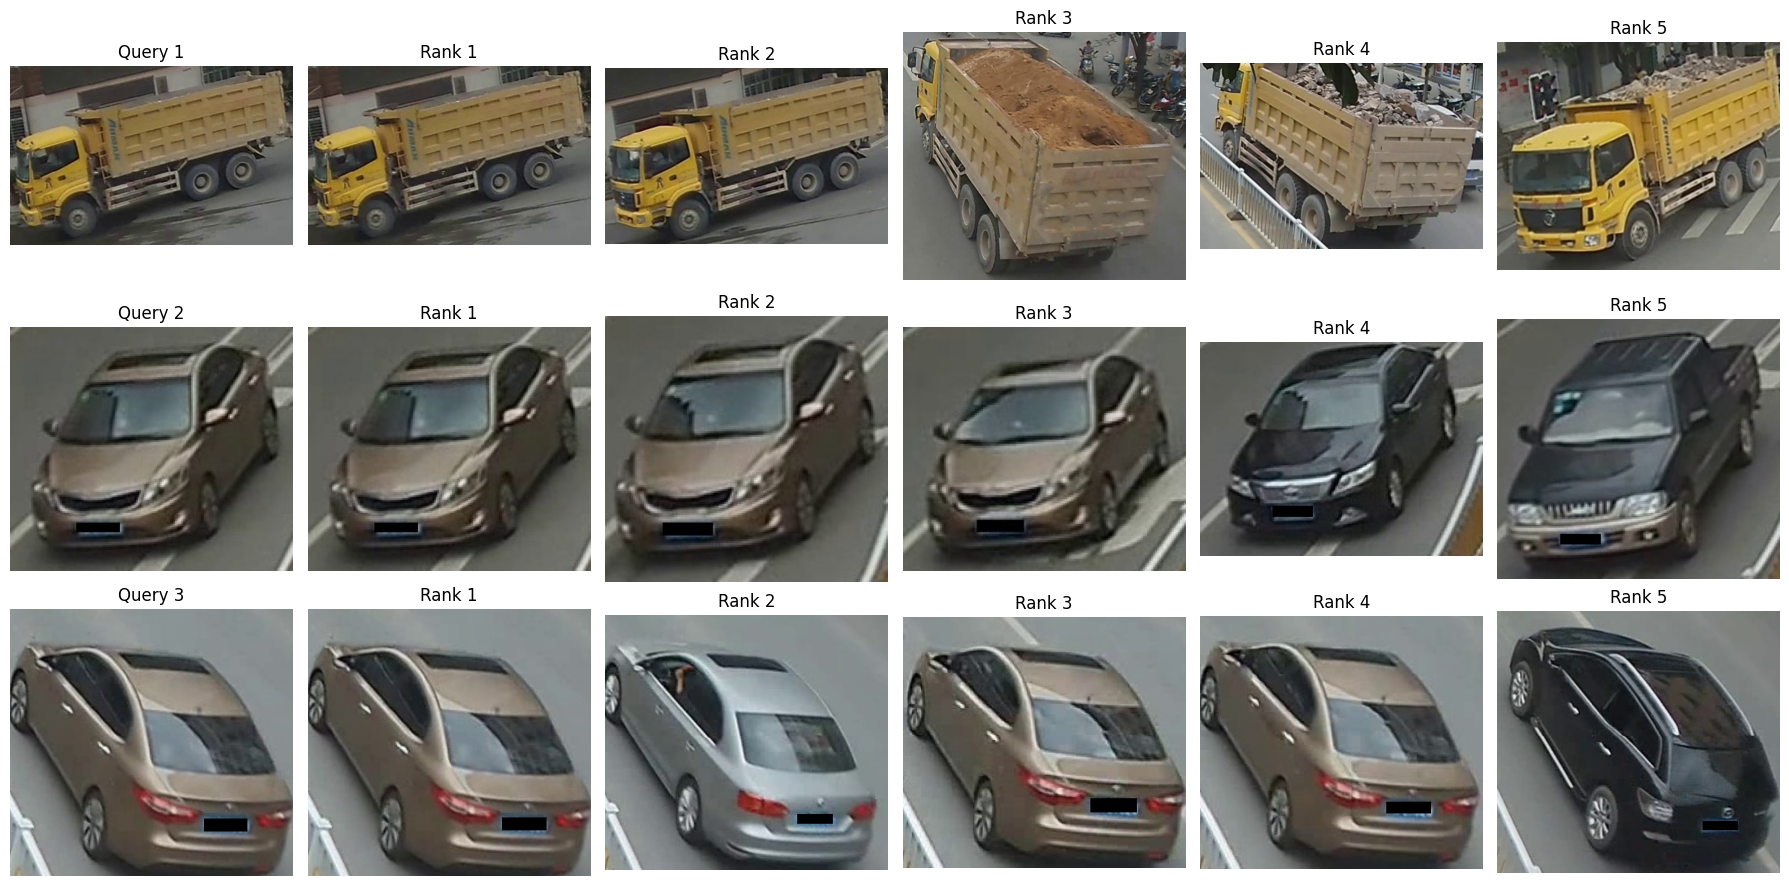

In [ ]:
# Visualize top ranked images for random query images
visualize_top_ranked_images(query_images, query_embeddings, test_images, test_embeddings)

Query 1 image name: 0486_c015_00075090_1.jpg
Rank 1 image name: 0486_c015_00075090_1.jpg
Rank 2 image name: 0486_c015_00075095_1.jpg
Rank 3 image name: 0486_c015_00075100_1.jpg
Rank 4 image name: 0642_c016_00020150_0.jpg
Rank 5 image name: 0166_c016_00034920_0.jpg
Query 2 image name: 0696_c015_00086985_0.jpg
Rank 1 image name: 0696_c015_00086985_0.jpg
Rank 2 image name: 0602_c015_00032995_1.jpg
Rank 3 image name: 0696_c015_00086995_0.jpg
Rank 4 image name: 0602_c015_00033000_1.jpg
Rank 5 image name: 0585_c006_00025720_0.jpg
Query 3 image name: 0461_c014_00017305_0.jpg
Rank 1 image name: 0461_c014_00017305_0.jpg
Rank 2 image name: 0480_c014_00077280_0.jpg
Rank 3 image name: 0361_c014_00038060_1.jpg
Rank 4 image name: 0768_c014_00058365_0.jpg
Rank 5 image name: 0768_c014_00058370_0.jpg


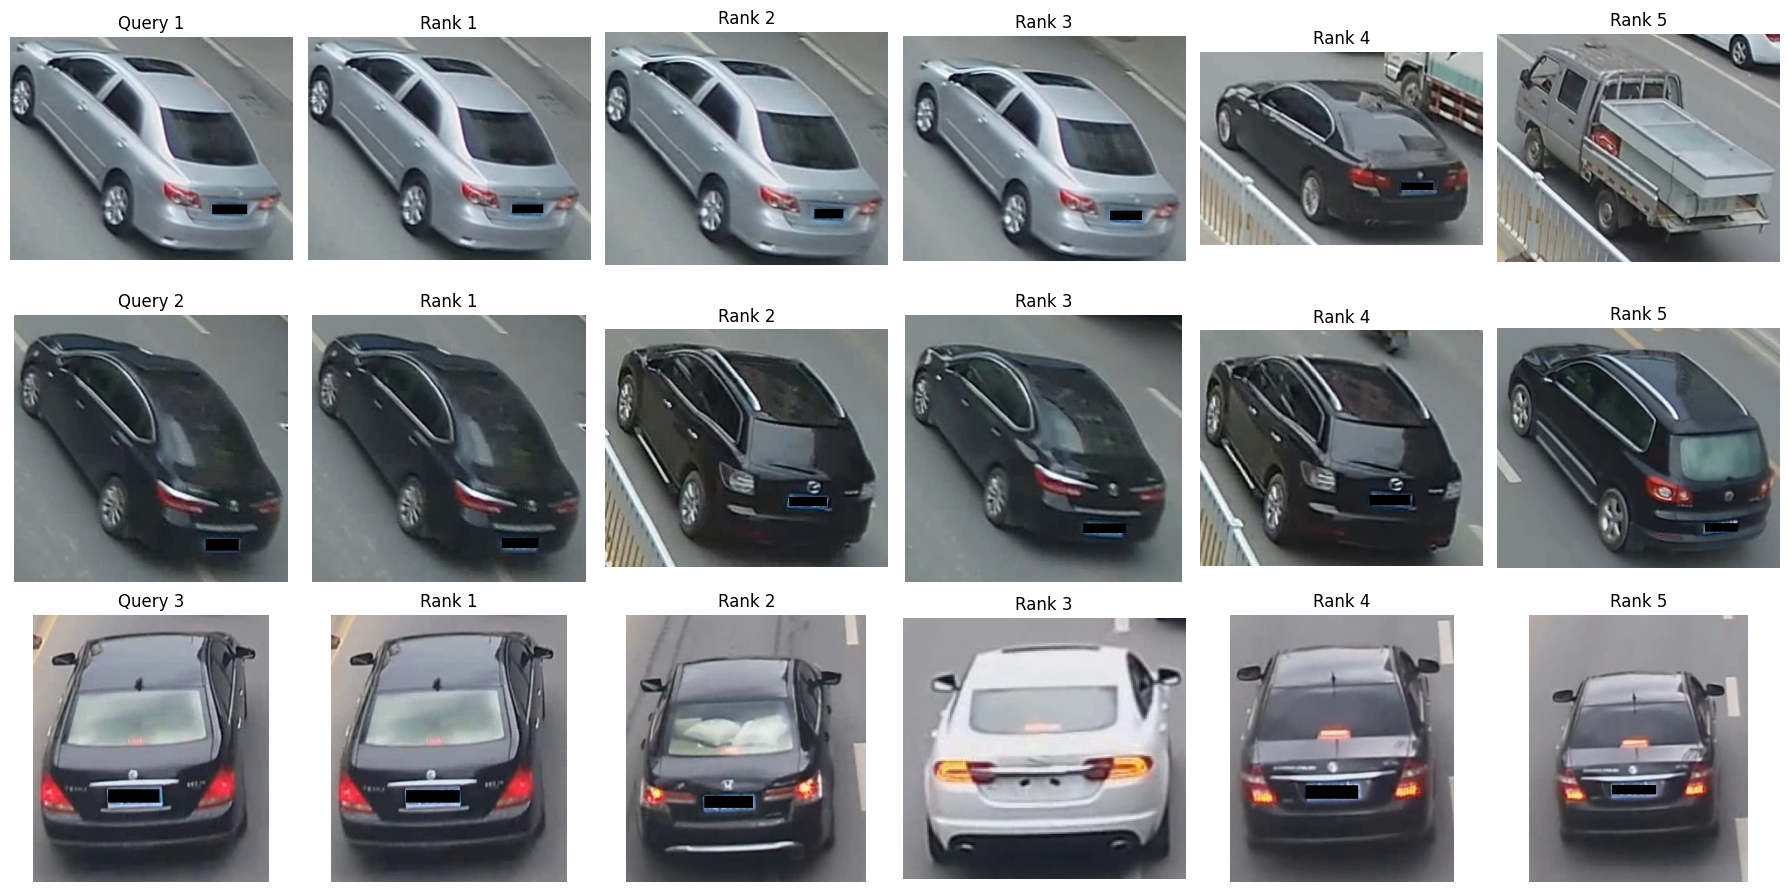

In [ ]:
# Visualize top ranked images for random query images
visualize_top_ranked_images(query_images, query_embeddings, test_images, test_embeddings)
